In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.gridspec as gsp
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
import scipy.stats as stats 
%config InlineBackend.figure_format = 'retina'
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))  
from scipy.special import gamma, factorial,digamma
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import scipy.special as sp 
from scipy import integrate
from joblib import Parallel, delayed

import sys
sys.path.append(r'/Users/ys18223/Documents/GitHub/FLAIR_BiocomputeLab')

import flair
import flair.inference as infer
import flair.simulations as sim
import flair.cheat_codes as cc

# Create instance of class Simulation

In [2]:
df=pd.read_csv('Taniguchi_data.csv')
print('The diversity of the library is: ',len(df))
Theta1=df.iloc[:,0].to_numpy() 
Theta2=10*df.iloc[:,1].to_numpy() #Fluorescence protein ratio
Diversity=len(df)
Fluorescence_max=10**5
Bins=8
Distribution='gamma'
N=1E6
Ratio_amplification=100
Budget_reads=1e7 
Bias_library=False
# Create an instance of class experiment
Simulation=flair.Simulation(Bins,Diversity,N,Budget_reads,Fluorescence_max,Distribution,Ratio_amplification,Theta1,Theta2,Bias_library)

The diversity of the library is:  1018


In [3]:
df.head()

,A_Protein,B_Protein
0,4.935,3.401
1,6.020,3.514
2,7.660,353.058
3,7.115,10.637
4,6.770,1.931


# Conduct inference

In [4]:
Sij,Nj=sim.Sorting_and_Sequencing(Simulation)
print(Nj)
Reads=np.sum(Sij,axis=0)
Sij=Sij.astype(int)
N=sum(Nj)
print(Sij[:10,:])
print('the number of effective cells is ',np.sum(Nj)/len(df))
Experiment=flair.Experiment(Bins,Diversity,Nj,Reads,Sij,Fluorescence_max,Distribution)

[104460.  86223. 201764. 283865. 202912.  84486.  28291.   5914.]
[[   0    0  760 8278  414    0    0    0]
 [   0    0  188 8338 1116    0    0    0]
 [   0    0    0    0    0    0 3804 5565]
 [   0    0    0  283 9145  353    0    0]
 [   0    0 1069 8511   18    0    0    0]
 [   0    0    0  405 9327   90    0    0]
 [   0    0    0 3977 5523    0    0    0]
 [   0    0    0 1077 8171    0    0    0]
 [   0    0    0    0  222 6971 2649    0]
 [8397 1146  496   20    0    0    0    0]]
the number of effective cells is  980.270137524558


In [41]:
w=len(Sij)
p=infer.inference(0,w,Experiment) #inference results are stored in this matrix
#Add ground truth and basic statistics to compare 
p['Mean'],p['standard deviation']=cc.ab_to_ms(Theta1,Theta2)
p['mu_ML'],p['sigma_ML']=cc.ab_to_ms(p['a_MLE'],p['b_MLE'])
p['a'],p['b']=Theta1,Theta2
# p['mu_MOM'],p['sigma_MOM']=cc.ab_to_ms(p['a_MOM'],p['b_MOM'])

In [42]:
p.tail()

,a_MLE,b_MLE,a_std,b_std,mu_MOM,sigma_MOM,Inference_grade,Score,Mean,standard deviation,mu_ML,sigma_ML,a,b
1013,9.919185,385.517233,0.309501,10.553018,4367.130007,3045.109037,1.0,0.000000,3817.36170,1241.459469,3824.016837,1214.176424,9.455,403.74
1014,3.784333,23.132259,0.104440,0.745688,127.968269,74.854917,1.0,0.000000,87.25900,46.312269,87.540163,45.000019,3.550,24.58
1015,4.680126,13.542314,0.110307,0.327752,90.436209,68.905485,1.0,0.000000,63.24500,29.649713,63.379738,29.296899,4.550,13.90
1016,0.193287,26.736168,0.005661,1.054268,7.991972,17.007905,1.0,0.742625,5.50200,12.302846,5.167755,11.754402,0.200,27.51
1017,0.607048,28.043530,0.010657,0.672878,23.589897,34.577706,1.0,0.334724,16.99245,21.667981,17.023776,21.849640,0.615,27.63


In [15]:
p.sort_values('Mean',ascending=True)['mu_ML'][:850]

341      0.462385
543      0.656744
250      0.818542
489      0.924029
243      1.057547
          ...    
843    892.552336
555    891.811822
649    895.232036
174    911.717117
923    919.243477
Name: mu_ML, Length: 850, dtype: float64

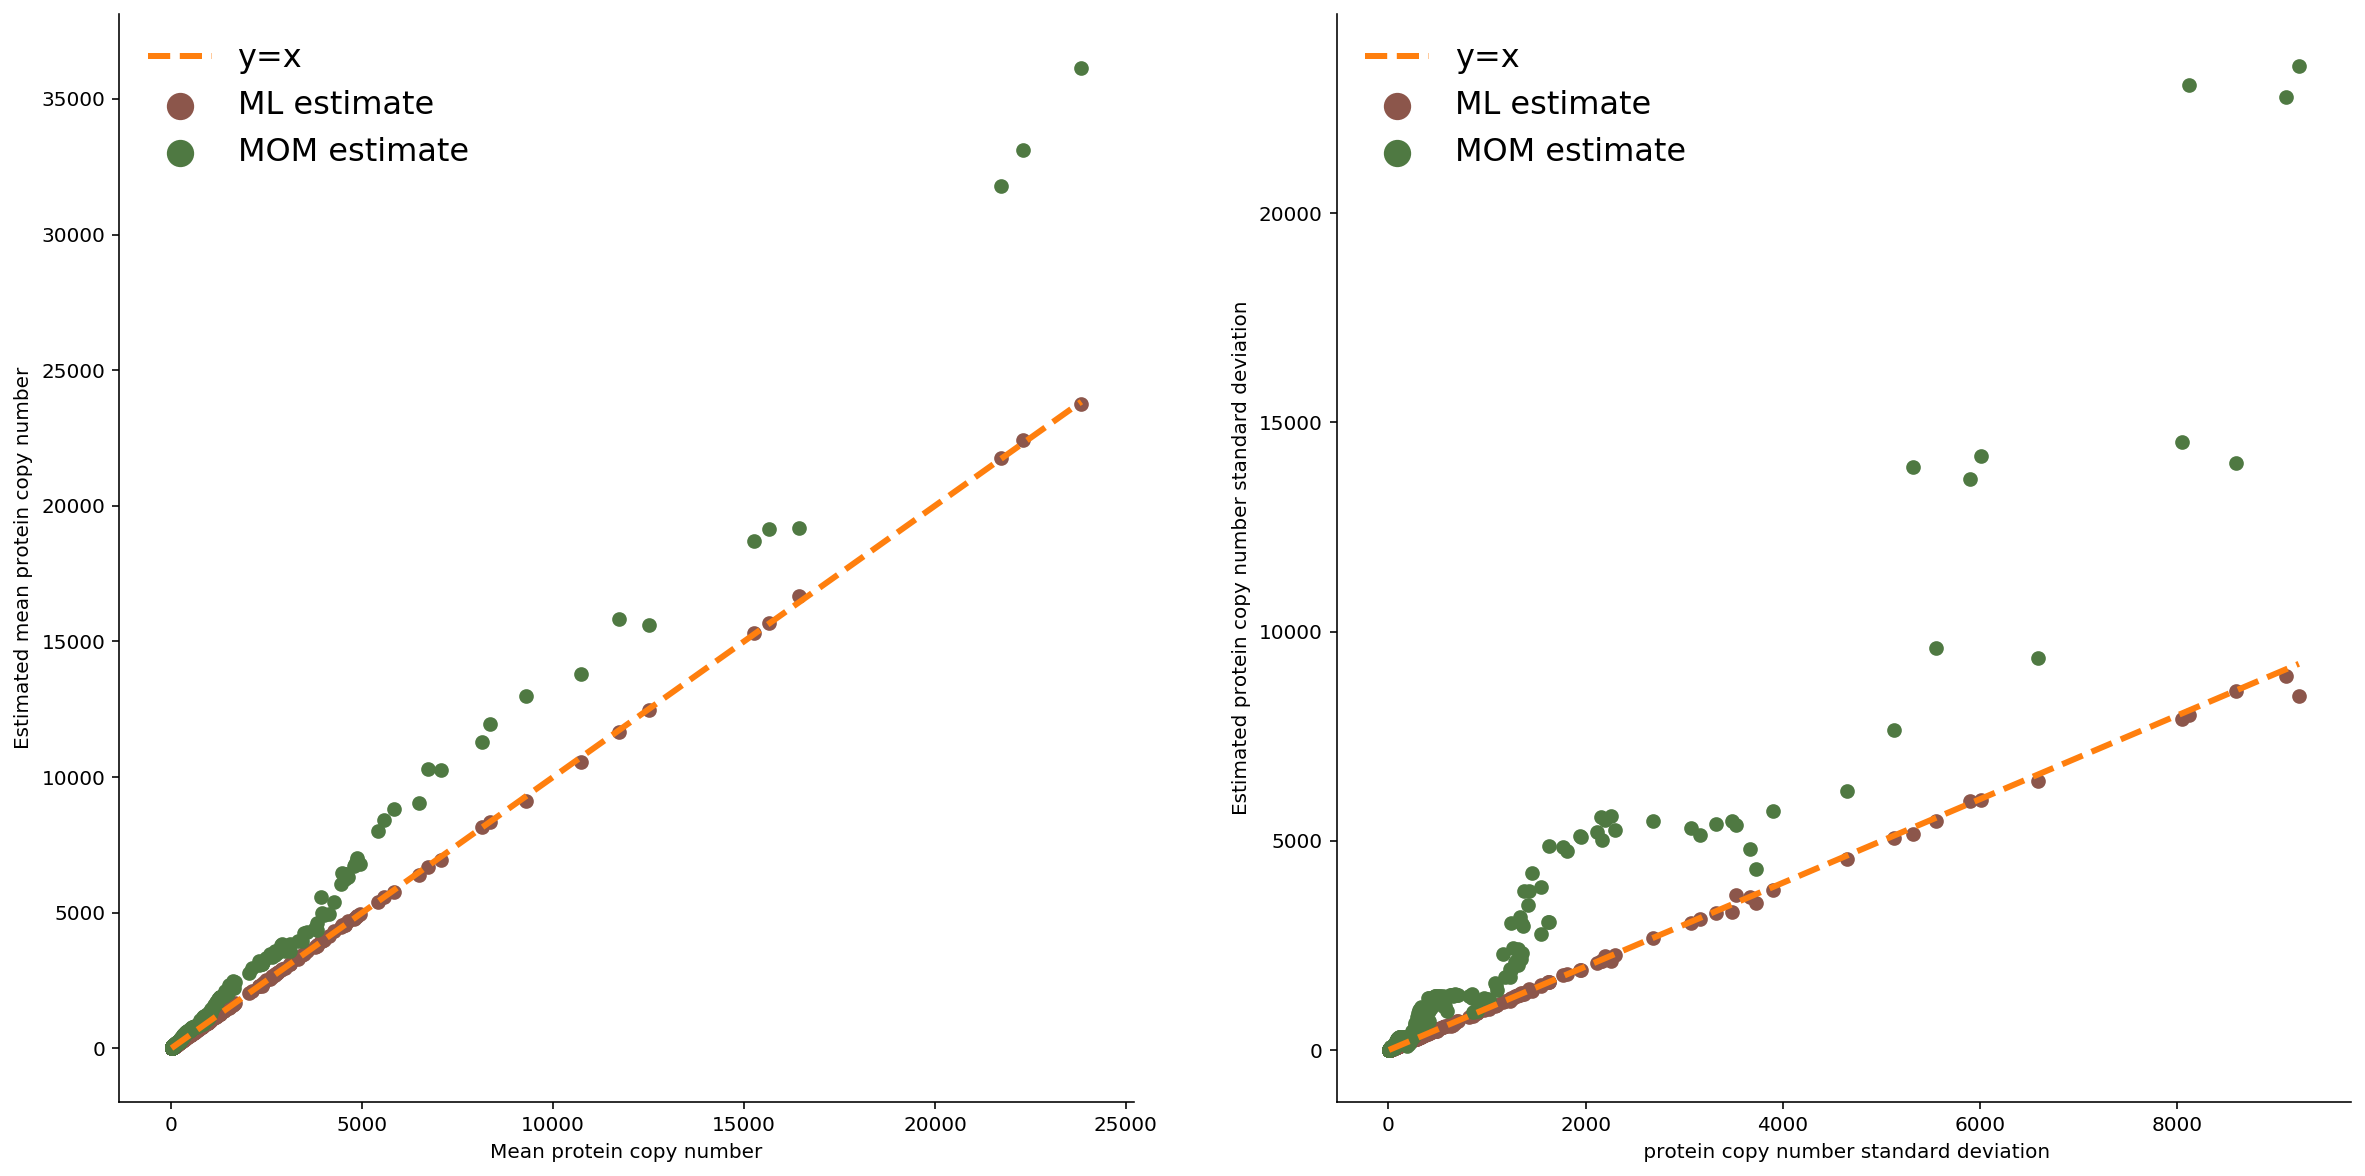

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,10))
#q.drop(q.index[[76,671]],inplace=True)

q=p[p['Score']<=0.6] #Keep constructs not on the border
q=q[q['Inference_grade']==1] #Keep contstructs with good shape
q=q[q['a_std']<q['a_MLE']]
q=q[q['b_std']<q['b_MLE']]

# X_mu=q.sort_values('Mean',ascending=True)['Mean'] 
# Y_mu=q.sort_values('Mean',ascending=True)['mu_ML'] 
# Z_mu=q.sort_values('Mean',ascending=True)['mu_MOM'] 
# X_sigma=q.sort_values('standard deviation',ascending=True)['standard deviation'] 
# Y_sigma=q.sort_values('standard deviation',ascending=True)['sigma_ML'] 
# Z_sigma=q.sort_values('standard deviation',ascending=True)['sigma_MOM'] 

X_mu=q.sort_values('Mean',ascending=True)['Mean']  
Y_mu=q.sort_values('Mean',ascending=True)['mu_ML']  
Z_mu=q.sort_values('Mean',ascending=True)['mu_MOM']  
X_sigma=q.sort_values('standard deviation',ascending=True)['standard deviation']   
Y_sigma=q.sort_values('standard deviation',ascending=True)['sigma_ML']   
Z_sigma=q.sort_values('standard deviation',ascending=True)['sigma_MOM']   

ax1.scatter(X_mu,Y_mu,s=40,c='tab:brown',label='ML estimate')
ax1.scatter(X_mu,Z_mu,s=40,c='#4f7942',label='MOM estimate')
ax1.plot(X_mu,X_mu,c='tab:orange',label='y=x',linewidth=3,linestyle='dashed')
ax1.legend()
ax1.set(xlabel='Mean protein copy number', ylabel='Estimated mean protein copy number')
#plt.title('')
ax1.legend(frameon=False,fontsize=16,markerscale=2)

ax2.scatter(X_sigma,Y_sigma,s=40,c='tab:brown',label='ML estimate')
ax2.scatter(X_sigma,Z_sigma,s=40,c='#4f7942',label='MOM estimate')
ax2.plot(X_sigma,X_sigma,c='tab:orange',label='y=x',linewidth=3,linestyle='dashed')
ax2.legend()
ax2.set(xlabel=' protein copy number standard deviation', ylabel='Estimated protein copy number standard deviation')
ax2.legend(frameon=False,fontsize=16,markerscale=2)

sns.despine()

In [36]:
len(q)

792

3.784332579357084 23.132259387296415 2.9225632746997023 43.7863124119227


/opt/miniconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


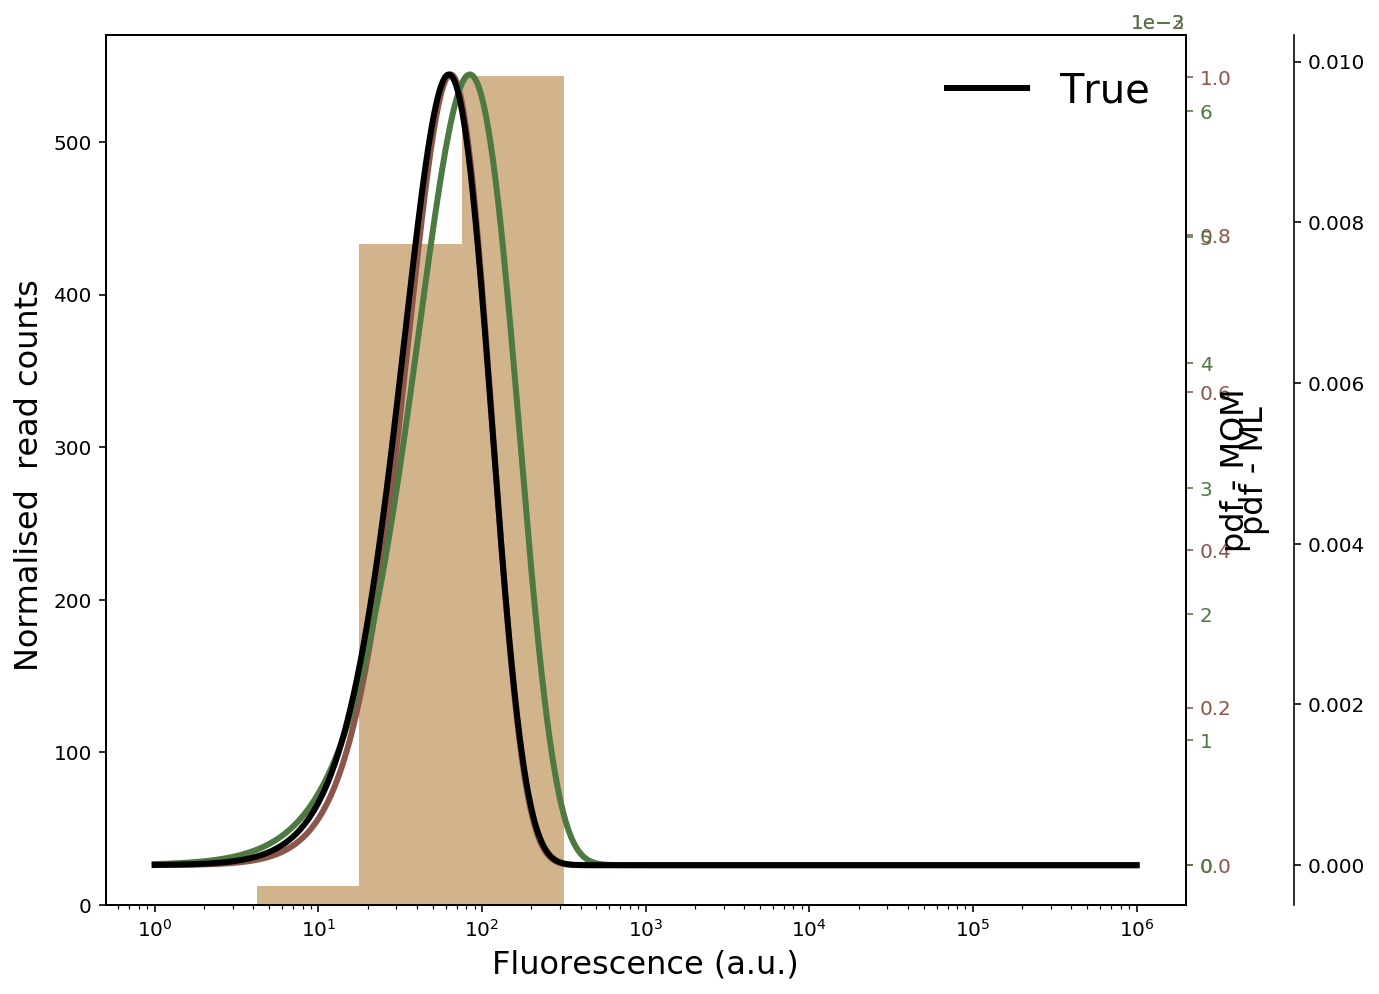

In [40]:
def data_transformation_bins(X):  #New representation of the data enabling the method of moments
    X=X.astype(int)
    T=np.repeat(Experiment.mean_assigned,X)
    return(T)

i=1014
x = np.linspace(1, 1e6, 5000000)
a =p.iloc[i,0]
b =p.iloc[i,1]
a2 =(p.iloc[i,4]**2)/(p.iloc[i,5]**2) #(10*p.iloc[i,4]/p.iloc[i,5])**2
b2= (p.iloc[i,5]**2)/p.iloc[i,4]

#Data
y_mle =stats.gamma.pdf(x, a, scale=b) # the normal pp
y_mom=stats.gamma.pdf(x, a2, scale=b2)
y=stats.gamma.pdf(x, p.iloc[i,12], scale=p.iloc[i,13])

#Graph
fig, ax = plt.subplots(figsize=(12,8))

# Twin the x-axis twice to make independent y-axes.
axes = [ax, ax.twinx(), ax.twinx(), ax.twinx()]

# Make some space on the right side for the extra y-axis.
fig.subplots_adjust(right=0.75)

# Move the last y-axis spine over to the right by 20% of the width of the axes
axes[-1].spines['right'].set_position(('axes', 1.1))

# To make the border of the right-most axis visible, we need to turn the frame
# on. This hides the other plots, however, so we need to turn its fill off.
axes[-1].set_frame_on(True)
axes[-1].patch.set_visible(False)
# And finally we get to plot things...
colors = ('tan','tab:brown', '#4f7942')
axes[0].hist(data_transformation_bins(Experiment.nijhat[i,:]),bins=np.logspace(0,np.log10(Fluorescence_max),Bins+1),zorder=0,color='tan',label='Read count')
axes[1].plot(x, y_mle, label='ML reconstruction',linewidth=3,zorder=5,color='tab:brown')
axes[2].plot(x, y_mom, label='MOM reconstruction',linewidth=3,zorder=3,c='#4f7942')
axes[3].plot(x, y, label='True',linewidth=3,zorder=3,c='black')

axes[0].set_ylabel('Normalised  read counts ',fontsize=16)
axes[1].set_ylabel('pdf - ML',fontsize=16)
axes[2].set_ylabel('pdf - MOM',fontsize=16)
plt.legend(frameon=False ,fontsize=20,markerscale=3)
axes[1].tick_params(axis='y', colors=colors[1])
axes[2].tick_params(axis='y', colors=colors[2])
axes[0].set_xlabel('Fluorescence (a.u.)',fontsize=16)
axes[1].ticklabel_format(axis="y",style="sci", scilimits=(0,0))
axes[2].ticklabel_format(axis="y",style="sci", scilimits=(0,0))
plt.xscale('log')
print(a,b,a2,b2)